In [ ]:
!pip install livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Morning Session 6: Generative Adversarial Networks (GANs)

GANs is a very popular generative model in almost all the deep-learning disciplines.

Instead of explicitly measuring the sample-wise distances of generated data samples and training data samples, GANs trains the generator against another network (adversarial loss). This has advantages:
1. GANs directly minimises the JS-divergence between $p_{G}$ and $p_{data}$;
2. Fit to the complex real data distribution;
3. Generate more realistic data.

Some good examples of GANs are (we are only doing the basic version in our practise):
1. [Generating photorealistic human face](https://thispersondoesnotexist.com/),
2. [Generating anime characters](https://towardsdatascience.com/generating-anime-characters-with-stylegan2-6f8ae59e237b),
3. [Generating arts](https://medium.com/swlh/using-gans-to-create-art-e3127c6902b3),
4. [Generating cats](https://ajolicoeur.wordpress.com/cats/).



![](https://cdn-media-1.freecodecamp.org/images/m41LtQVUf3uk5IOYlHLpPazxI3pWDwG8VEvU)

Image credit: [Thalles Silva](https://www.freecodecamp.org/news/an-intuitive-introduction-to-generative-adversarial-networks-gans-7a2264a81394/)


GANs plays a min-max optimisation:

$$\min_G \max_D V_{GAN}(D,G) = \mathbb E_{x\sim p_{data}}[\log D(x)] + \mathbb E_{z\sim p_z}[\log (1-D(G(z)))]$$

That is:
* The discriminator trys to label a Real image (from training data) to be Real and a Fake image (generated by the generator) to be Fake;
* The generator trys to "fool" the discriminator -- to let it label the Fake image to be Real.

As training goes on, the two networks compete and envolve:
* Generator generates more and more realistic images;




#### A few imports before we get started

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import random 
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


### Mounting the google drive for later storage

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


### Exercise: Implementing the Deep Neural Networks

In this session you will implement a simple GANs using the MNIST dataset.

A GAN is a generative model that is trained using two competing neural networks:
* The Generater network ($G$) is consisted of 4 Linear layers;
* the Discriminator network ($D$) is a classifier consists of 4 Linear layers.

Latent vector length: 100

Network G:
1. Layer 1: 100 -> 256 (100 is length of latent vector)
2. Layer 2: 256 -> 512
3. Layer 3: 512 -> 1024
4. Layer 4: 1024 -> 784 (size of a MNIST image)

Apply leaky_relu(alpha=0.2) activation functions for layers 1-3, and tanh to layer 4.
* Leaky_relu helps to mitigate Vanishing gradient problem

Network D:
1. Layer 1: 784 -> 1024 
2. Layer 2: 1024 -> 512 
3. Layer 3: 512 -> 256 
3. Layer 4: 256 -> 1 (We want to label if input is a real image, not to find which number is in the image.)


Apply leaky_relu(alpha=0.2) activation functions for layers 1-3, and sigmoid to layer 4. Can also apply low rate dropout (0.3) at layers 1-3.

Note although here we have used the Linear layers for MNIST, for larger image-sized implementations, it usually uses convolutional layers.




In [ ]:
class Generator(nn.Module):
  def __init__(self, g_input_dim=100, g_output_dim=28*28):
    super().__init__()       
    # define the layers of G
    
  
  def forward(self, x): 
    # forward the model

    # return the generated tensor
    
  
class Discriminator(nn.Module):
  def __init__(self, d_input_dim=28*28):
    super().__init__()
    # define the layers of D

  def forward(self, x):
    # forward the model

    # return the output
    

# build model
G = Generator().to(device)
D = Discriminator().to(device)

Print  $G$  and  $D$

In [ ]:
G

In [ ]:
D

Loss and hyper-parameters:
* Loss criterion -- BCELoss
* batch_size = 100
* learning_rate = 0.0002
* Optimisor -- Adam

In [ ]:
# define loss

# define batch size and dimension of z

# optimizer


In [ ]:
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = MNIST(root='./mnist_data/', train=True, transform=transform, download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)

GANs aims to let the generator and the discriminator to compete, here are the steps to follow to train this GANs:
1. Fix $G$, train $D$ to distinguish real images (x) and generator output fake images ($G(z)$):
  * $D(x) \rightarrow$ high score,
  * $D(G(z)) \rightarrow$ low score.
2. Fix $D$, train $G$ to "fool" $D$:
  * sample a vector $z$,
  * generate the fake image $G(z)$,
  * input $G(z)$ into $D$,
  * train $G$ to increase the score of $D(G(z))$ (here $G$ and $D$ can be understood as one combined network, but layers of $D$ are freezed).

Note: If you found one of the losses becomes zero at the first several epochs, it means the trianing is not robust due to the initialisation (one network outperforms the other and the other cannot catch up anymore). Need to rerun the processes.

In [ ]:
def D_train(x):
  #-------------- Function of the discriminator training -------------------#
  # zero_grad

  # 1. train discriminator on real data -- assign high score (1)
  # 1.1 real data and target score
  # 1.2 send to device and wrap with Variable

  # 1.3 input real data into D to generate D_output
  # 1.4 compute loss D_real_loss

  # 2. train discriminator on fake data -- assign low score (0)
  # 2.1 sample vector z from latent space
  # 2.2 input z into G to produce fake data
  # 2.3 make target scores for fake data

  

  # 2.4 input fake data into D to generate D_output
  # 2.5 compute loss D_fake_loss


  # 3. combine the losses D_real_loss and D_fake_loss into D_loss

  # model update 

      
  return  D_loss.data.item()


In [ ]:
def G_train(x):
  #-------------- Function of the generator training -------------------#
  # zero_grad

  # 1. sample vector z
  # 2. input z into G to produce fake data

  # 3. obtain scores from D for the generated data

  # 4. train generator to "fool" discriminator by using socre
  # 4.1 use 1 as the target score for fake data
  # 4.2 compute G_loss

  # model update 
      
  return G_loss.data.item()

In [ ]:
n_epoch = 200 # about 40 minutes
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

#-------------- Train GAN -------------------#
for epoch in range(1, n_epoch+1):  
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, (x, _) in enumerate(train_loader):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

  # save every 20th epochs
  if(np.mod(epoch, 20) == 0):
    torch.save(G.state_dict(), "./Generator_{:03d}.pth".format(epoch))

### Sample random latent vectors, and input into generator to generate images.

In [ ]:
# from torchvision.utils import save_image
set_seed(0)

epoch = 20
G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))


with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)

    # save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')
fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 28, 28).cpu()):
  ax.imshow(img, cmap="gray")
plt.title('Epoch = {:03d}'.format(epoch))

In [ ]:
# from torchvision.utils import save_image
set_seed(0)

epoch = 60
G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))


with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)

    # save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')
fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 28, 28).cpu()):
  ax.imshow(img, cmap="gray")
plt.title('Epoch = {:03d}'.format(epoch))

In [ ]:
# from torchvision.utils import save_image
set_seed(0)

epoch = 140
G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))


with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)

    # save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')
fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 28, 28).cpu()):
  ax.imshow(img, cmap="gray")
plt.title('Epoch = {:03d}'.format(epoch))

In [ ]:
# from torchvision.utils import save_image
set_seed(0)

epoch = 200
G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))


with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)

    # save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')
fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 28, 28).cpu()):
  ax.imshow(img, cmap="gray")
plt.title('Epoch = {:03d}'.format(epoch))

Compare against VAEs


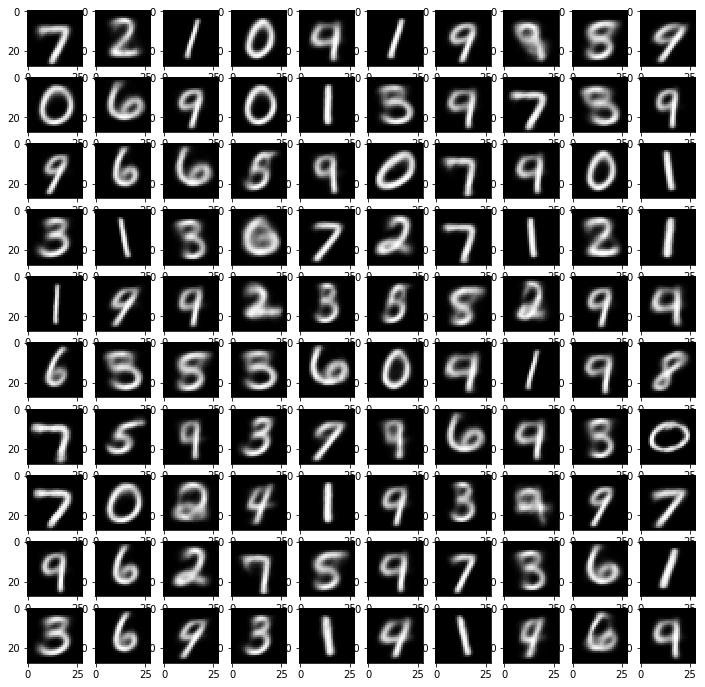